In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline
from IPython import display
import tensorflow as tf
import tensorflow_probability as tfp


In [3]:
import os
import glob

In [4]:
def gauss_mixture25(batch_size):
        n = 5
        stddev = np.sqrt(0.00001)
        x = np.linspace(-1.0,1.0,5)
        y = np.linspace(-1.0,1.0,5)
        mus = [[x0, y0] for x0 in x for y0 in y]
        sigma = [[stddev,0], [0,stddev]]
        gms_x = []
        gms_y = []
        for _ in range(batch_size):
            mu = mus[np.random.choice(len(mus))]
            gm = np.random.multivariate_normal(mu, sigma)
            gms_x.append(gm[0])
            gms_y.append(gm[1])
        gms_x = np.array(gms_x)
        gms_y = np.array(gms_y)
        return(gms_x, gms_y)

In [5]:
def square(batch_size):
    return np.random.uniform(-1.0, 1.0, batch_size), np.random.uniform(-1.0, 1.0, batch_size)

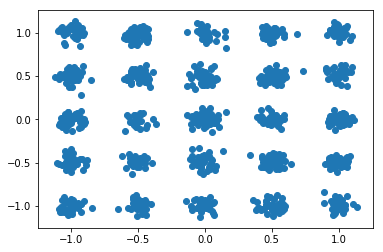

In [6]:
manifold = gauss_mixture25
#manifold = square
gms_x, gms_y = manifold(1000)
plt.scatter(gms_x, gms_y)

In [7]:
def sq_dists(A, B):
    '''
    https://medium.com/dataholiks-distillery/l2-distance-matrix-vectorization-trick-26aa3247ac6c
    '''
    if len(A.get_shape().as_list())==1:
        A = tf.expand_dims(A,1)
    if len(B.get_shape().as_list())==1:
        B = tf.expand_dims(B,1)
    A2 = tf.expand_dims(tf.reduce_sum(A**2, axis=1),1)
    B2 = tf.reduce_sum(B**2, axis=1)
    ABAB = 2 * tf.matmul(A, tf.transpose(B))
    dists = A2 + B2 - ABAB 
    return dists

In [62]:
def train(batch_size, latentsize, num_iter,
          lr_init, beta1, beta2, lmbda,
          out_fn, n_layers_g, n_hidden_g, n_layers_d, n_hidden_d,
          use_batchnorm_g, use_batchnorm_d,
          plot_dir):
    
    LAMBDA = lmbda
    
    tf.reset_default_graph()
    
    learning_rate = tf.Variable(lr_init, trainable=False)
    lr_val = tf.placeholder(tf.float32)
    lr_assign = tf.assign(learning_rate, lr_val)
   
    z1 = tf.random.normal([batch_size, latentsize], name="z1")
    z2 = tf.random.normal([batch_size, latentsize], name="z2")
    z2_s = tf.squeeze(z2)
    
    x1 = generator(z1, tf.nn.relu, out_fn, n_layers_g, n_hidden_g,
                   use_batchnorm_g)
    #x1 = tf.identity(x1[-1], name='gen_out')
    x1 = x1[-1]
    
    x2 = generator(z2, tf.nn.relu, out_fn, n_layers_g, n_hidden_g,
                   True, training=True, reuse_vars=True)
    #x2 = tf.identity(x2[-1], name='gen2_out')    
    x2 = x2[-1]
    
    #z_lin_np = np.expand_dims(np.linspace(0.0,1.0,1000,dtype=np.float32),1)
    #z_lin = tf.constant(z_lin_np)
    z_lin = tf.random_normal([1000,1])
    z_lin = tf.sort(z_lin, 0)
    #z_lin = tf.random.normal([64,1])
    #z_lin = tf.sort(z_lin, 0)
    x_lin = generator(z_lin, tf.nn.relu, out_fn, n_layers_g, n_hidden_g,
                      True, training=True, reuse_vars=True)
    #x_lin = tf.identity(x_lin[-1], name='gen_interp')
    x_lin = x_lin[-1]
    
    #y1 = tf.random.uniform([batch_size, 2], name="y1")
    y1 = tf.placeholder(tf.float32, shape=(batch_size, 2))
    
    disc_x = discriminator(x1, n_layers_d, n_hidden_d,
                  use_batchnorm=use_batchnorm_d, reuse_vars=False)
    disc_x = tf.squeeze(disc_x[-1], name='disc_x_out')
    disc_y = discriminator(y1, n_layers_d, n_hidden_d,
                  use_batchnorm=use_batchnorm_d, reuse_vars=True)
    disc_y = tf.squeeze(disc_y[-1], name='disc_y_out')
        
    ##### Potential
    
    
    ##### Discriminator loss
    
    disc_cost_real = -tf.reduce_mean(disc_y)
    disc_cost_gen  = tf.reduce_mean(disc_x)
    disc_cost_ws = disc_cost_gen + disc_cost_real
    gen_cost_gen = -disc_cost_gen
    
    loss_d = disc_cost_ws
    
    # WGAN lipschitz-penalty
    alpha = tf.random_uniform(
        shape=[batch_size,1],
        minval=0.,
        maxval=1.
    )
        
    differences = x1 - y1
    interpolates = y1 + (alpha * differences)
    gradients = tf.gradients(discriminator(interpolates, n_layers_d, n_hidden_d,
                  use_batchnorm=use_batchnorm_d, reuse_vars=True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_max((slopes-1.)**2)
    loss_d += LAMBDA * gradient_penalty
    disc_cost_gp = loss_d
    
    ##### Generator loss
    
    loss_g = gen_cost_gen
    
    z_dist = sq_dists(z, z) # Distance matrix batch z
    y_dist = sq_dists(y, y) # Distance matrix batch y
    corr_zy = tfp.stats.correlation(z_dist, y_dist)
    corr_reward = tf.trace(corr_zy)
    loss_g -= 0.1 * corr_reward
    
    
    differences = z1 - z2
    interpolates = z2 + (alpha * differences)
    #interpolates = z_interp
    gradients = tf.gradients(generator(interpolates, tf.nn.relu, out_fn, n_layers_g, n_hidden_g,
                                       use_batchnorm_g, reuse_vars=True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients)+1e-10, reduction_indices=[1]))
    gradient_penalty = tf.reduce_max((slopes)**2)
    #loss_g += 0.1 * gradient_penalty
    
    
    #### Optimizers
    
    optim_d = tf.train.AdamOptimizer(learning_rate * 1.0,
                                     beta1=beta1,
                                     beta2=beta2)
    optim_g = tf.train.AdamOptimizer(learning_rate,
                                     beta1=beta1,
                                     beta2=beta2)

    ##### Train ops
    
    vars_d = [v for v in tf.global_variables() if v.name.startswith('discriminator')]
    vars_g = [v for v in tf.global_variables() if v.name.startswith('generator')]
        
    # we can sum all regularizers in one term, the var-list argument to minimize
    # should make sure each optimizer only regularizes "its own" variables
    regularizers = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

    #gradients, _ = zip(*optim_d.compute_gradients(loss_d, vars_d))
    #gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    #train_op_d = optim_d.apply_gradients(zip(gradients, vars_d))

    #gradients, _ = zip(*optim_g.compute_gradients(loss_g, vars_g))
    #gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    #train_op_g = optim_d.apply_gradients(zip(gradients, vars_g))
    
    train_op_d = optim_d.minimize(loss_d + regularizers, var_list=vars_d)
    train_op_g = optim_g.minimize(loss_g + regularizers, var_list=vars_g)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # for batchnorm
    train_op = tf.group(train_op_d, train_op_g, update_ops)

    ##### Session
    
    config = tf.ConfigProto(intra_op_parallelism_threads=2,
                            inter_op_parallelism_threads=2,
                            use_per_session_threads=True,
                            gpu_options = tf.GPUOptions(allow_growth=True))

    with tf.Session(config=config) as sess:

        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        lr = lr_init
        
        format_string = "\r%d/%d tr: %.2f d_real: %.2f d_gen: %.2f d_ws: %.2f d_gp: %.2f g_gen: %.2f g_gp: %.2f"
        
        for cur_iter in range(num_iter + 1):
            
            if (cur_iter + 1) % 100 == 0:
                i = cur_iter - 1
                format_feed = (i + 2, num_iter, ret_dict["trl"],
                               ret_dict["dcr"], ret_dict["dcg"], ret_dict["dcws"],
                               ret_dict["dcgp"], ret_dict["gcg"], ret_dict["gcgp"])

                print(format_string % format_feed, end="", flush=True)
           
            '''  
            if cur_iter % 10000 == 0:
                lr  /= 2.0 
                sess.run(lr_assign, feed_dict={lr_val: lr})
            '''
            
            ms = manifold(batch_size)
            ms = np.vstack((ms[0], ms[1])).T
            
            feed_dict = {y1: ms}
            
            ops_dict = {"train_op" : train_op,
                        "trl" : tr_loss,
                        "dcr" : disc_cost_real,
                        "dcg" : disc_cost_gen,
                        "dcws" : disc_cost_ws,
                        "dcgp" : disc_cost_gp,
                        "gcg" : gen_cost_gen,
                        "gcgp" : loss_g,
                        "x1": x1,
                        "x_lin" : x_lin,
                        "y1": y1}
            
            ret_dict = sess.run(ops_dict, feed_dict)
            
            if cur_iter % 1000 == 0:
                n = 1000
                #real_ms = [sess.run(y1) for _ in range(n//batch_size)]
                #real_ms = np.vstack(real_ms)
                #real_ms = real_ms.T
                real_ms = manifold(n)
                real_ms = np.vstack((real_ms[0], real_ms[1]))
                for i in range(1):
                    
                    m = []
                    for _ in range(500//batch_size):
                        gen_lin, z2s = sess.run([x2, z2])
                        m.append(np.concatenate((gen_lin, z2s), axis=1))
                    m = np.vstack(m)
                    m = m[m[:,2].argsort()] # sort by z
                    gen_lin = m[:,:2].T       
                    
                    #gen_lin = sess.run(x_lin)
                    #gen_lin = gen_lin.T
                    gen_ms = [sess.run(x2) for _ in range(n//batch_size)]
                    gen_ms = np.vstack(gen_ms)
                    gen_ms = gen_ms.T
                    plt.figure(figsize=(5,5))
                    plt.xlim((-1.5, 1.5))
                    plt.ylim((-1.5, 1.5))
                    plt.scatter(real_ms[0][:n], real_ms[1][:n], zorder=0, label="real")
                    #plt.scatter(gen_ms[0][:n], gen_ms[1][:n], label="gen")
                    plt.plot(gen_lin[0], gen_lin[1], c="green", zorder=1, label="gen_lin")
                    colormap = cm.hot(np.linspace(0, 1, len(gen_lin[0])))
                    seq = np.arange(start = 0, stop = len(gen_lin[0]), dtype = 'int')
                    color = colormap[seq]
                    plt.scatter(gen_lin[0], gen_lin[1], c=color, zorder=2, label="gen linspace")
                    #plt.plot(gen_lin[0], gen_lin[1], c="red", label="gen linspace")
                    #plt.plot(gen_ms[0], gen_ms[1], c="red", label="gen linspace")
                    #plt.legend()
                    plt.title("%d / %d" % (cur_iter, i))
                    fig = plt.gcf()
                    fig.savefig("/publicwork/mhe/Peano/%s/peano_%d_%08d.png" % (plot_dir, i, cur_iter), bbox_inches='tight')
                    plt.close(fig)
                
        print()
        
        gen_ms = [sess.run(x1) for _ in range(1000//batch_size)]
        gen_ms = np.vstack(gen_ms)
        
        results = {
            "dcr" : disc_cost_real,
            "dcg" : disc_cost_gen,
            "dcws" : disc_cost_ws,
            "dcgp" : disc_cost_gp,
            "gcg" : gen_cost_gen
        }        
        
    return(results)

In [67]:
plot_dir = "gauss_gl4gh128_dl8dh128_ggp0_tr0_1m_2"

In [68]:
full_plot_dir = "/publicwork/mhe/Peano/%s" % plot_dir
if not os.path.exists(full_plot_dir):
    print("does not exist")
    os.makedirs(full_plot_dir)

In [69]:
files = glob.glob("%s/*.png" % full_plot_dir)
for f in files:
    os.remove(f)

In [70]:
ret_dict = train(64, 1, 1000000,
                 lr_init=1e-4, beta1=0.0, beta2=0.9, lmbda=1.0,
                 out_fn="tanh", n_layers_g=4, n_hidden_g=128, n_layers_d=8, n_hidden_d=128,
                 use_batchnorm_g=True, use_batchnorm_d=False,
                 plot_dir=plot_dir)

1000000/1000000 tr: 4.06 d_real: 0.09 d_gen: -0.13 d_ws: -0.04 d_gp: -0.01 g_gen: 0.13 g_gp: 0.1332


In [13]:
from tensorflow.contrib import layers

def generator(z, act_fn=tf.nn.relu, out_fn="tanh", n_layers=2, n_units=100,
              use_batchnorm=True, trainable=True, training=True, reuse_vars=False):
    
    if out_fn == "tanh":
        out_fn_tf = tf.nn.tanh
    if out_fn == "sigmoid":
        out_fn_tf = tf.nn.sigmoid
    if out_fn is None:
        out_fn_tf = None
    
    with tf.variable_scope("generator", reuse=reuse_vars) as vs:
        
        #initializer = tf.initializers.truncated_normal(stddev=5.0)
        initializer = None       
        layers = []
        l = z
        for i in range(n_layers):
            name = "layer%d" % (i + 1)
            l = tf.layers.dense(l, n_units, activation=None, kernel_initializer=initializer, trainable=trainable, name=name)
            layers.append(l)
            if use_batchnorm:
                l = tf.layers.batch_normalization(l, training=training)
            l = act_fn(l)
            layers.append(l)
        l = tf.layers.dense(l, 2, activation=out_fn_tf, kernel_initializer=initializer, trainable=trainable, name="layer_out")
        if out_fn == "tanh":
            l *= 2.0
        layers.append(l)
        
        return layers
        #return l
    
def discriminator(x, n_layers=2, n_units=100,
                  use_batchnorm=True, reuse_vars=False):
    
    #act_fn = lambda x : tf.maximum(0.2 * x, x)
    act_fn = tf.nn.relu
    
    with tf.variable_scope("discriminator", reuse=reuse_vars) as vs:
        
        #initializer = tf.initializers.truncated_normal(stddev=0.05)
        initializer = None
        layers = []
        l = x
        for i in range(n_layers):
            name = "layer%d" % (i + 1)
            l = tf.layers.dense(l, n_units, activation=None, kernel_initializer=initializer, name=name)
            if use_batchnorm:
                l = tf.layers.batch_normalization(l, training=True)
            l = act_fn(l)
            layers.append(l)
        l = tf.layers.dense(l, 1, activation=tf.tanh, kernel_initializer=initializer, name="layer_out")
        layers.append(l)
        
        return layers
        #return l

In [ ]:
pot_xy = ret_dict["sigmas_xy_mat"]
plt.figure(figsize=(15,15))
plt.imshow(pot_xy, origin='lower', cmap='hot')
plt.title("xy")
plt.colorbar()
#fig = plt.gcf()
#fig.savefig("plots_toy/gauss_xy.png", bbox_inches='tight')

In [ ]:
x = np.arange(0, 100)
y = np.arange(0, 100)
X, Y = np.meshgrid(x, y)
Z =  pot_x
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.view_init(70, 35)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
fig = plt.gcf()
fig.savefig("plots_toy/gauss_3d_x.png", bbox_inches='tight')
plt.show()